In [1]:
import os
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import tensorflow as tf
tf.keras.utils.disable_interactive_logging()
import matplotlib.pyplot as plt

sys.path.append('../')
from src.iterative_enrichment.example_cycle import (
    reduce_df_class_imbalance_to_target,
    sample_seqs,
    get_X_y_train_val,
    get_cutoff_for_desired_recall
)
from src.classifiers.cnn.train import (
    fit_CNN
)
from src.iterative_enrichment.plotting import (
    plot_enrichment
)

2024-01-10 18:29:05.878510: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 18:29:05.878584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 18:29:05.880066: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 18:29:05.888842: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 18:29:06.889179: W tensorflow/compiler/tf2

### Load data

This data could be sequences generated using e.g. BLOSUM. However, for this example (where we cannot experimentally validate novel designs), we use HER2-aff-large with the binding enrichment reduced.

In [2]:
# experimental data
train_val_test_dir = os.path.abspath("../data/affinity_data/her2/her2_aff_large/processed/remove_overlap/random_split/0.7_0.15_0.15/")
train = pd.read_csv(os.path.join(train_val_test_dir, "train.csv"))
val = pd.read_csv(os.path.join(train_val_test_dir, "val.csv"))
test = pd.read_csv(os.path.join(train_val_test_dir, "test.csv"))
df = pd.concat([train, val, test], join="inner")
original_class_imbalance = df["label"].sum()/len(df)
print(f"Original class imbalance: {100*original_class_imbalance:.2f}%")

# filter out sequences so that class imbalance is X% (e.g. 10%)
target_class_imbalance = 0.1
df = reduce_df_class_imbalance_to_target(df, target_class_imbalance=target_class_imbalance)
new_class_imbalance = df["label"].sum()/len(df)
print(f"New class imbalance: {100*new_class_imbalance:.2f}%")

Original class imbalance: 32.83%
New class imbalance: 10.00%


### Run iterative cycle of improvement

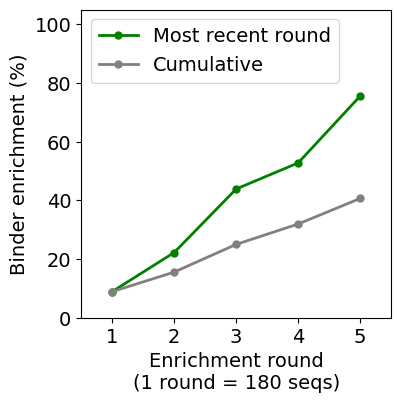

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [3]:
# create empty df with same columns as original df
# this df will contain all sequences we sample in the simulation
df_experimentally_tested = pd.DataFrame(columns=df.columns)

# initiate settings for simulation
max_num_rounds = 5                   # change this to run more rounds
num_sequences_to_sample = int(90*2)  # change this to sample more sequences per round
CNN = None
cutoff = 0
cutoffs = []
enrichments_latest_round = [None]*max_num_rounds
enrichments_cumulative = [None]*max_num_rounds

# run simulation
for round in range(max_num_rounds):

    # sample seqs (latest round and cumulative)
    df_sampled_sequences = sample_seqs(df, num_sequences_to_sample, df_experimentally_tested, CNN=CNN, cutoff=cutoff)
    df_experimentally_tested = pd.concat([df_experimentally_tested, df_sampled_sequences])

    # update enrichments
    enrichments_latest_round[round] = 100*df_sampled_sequences["label"].sum()/len(df_sampled_sequences)
    enrichments_cumulative[round] = 100*df_experimentally_tested["label"].sum()/len(df_experimentally_tested)

    # plot enrichments (figure updates after each round)
    plot_enrichment(enrichments_latest_round, enrichments_cumulative, max_num_rounds, num_sequences_to_sample)

    # split all available labelled data into train and val
    X_train, y_train, X_val, y_val = get_X_y_train_val(df_experimentally_tested)

    # train CNN
    epochs = 100
    patience = 5
    batch_size = 32
    input_shape = (X_train.shape[1], X_train.shape[2])
    CNN, history = fit_CNN(X_train, y_train, X_val, y_val, epochs=epochs, verbose=None,
                           batch_size=batch_size, input_shape=input_shape, patience=patience)

    # get cutoff to use to when screening future sequences
    predictions = CNN.predict(X_val)
    desired_recall = 0.8
    cutoff = get_cutoff_for_desired_recall(y_val, predictions, desired_recall=desired_recall)
    cutoffs.append(cutoff)

plt.clf()